In [99]:
# Importing numpy and functions
import numpy as np
import helpers as h
from implementations import *
from matplotlib import pyplot as plt


In [4]:

# Loading the data
X, xHeader, Y, yHeader, indexedX, indexedXheader, indexedY, indexedYheader = loadTrainingData()
print('')
# Cleaning/feature engineering the data
yClean, xClean, xHeaderClean, removedFeatures = dataCleaning(Y,X,xHeader)
print('')
# Making a balanced data set to force the model to not just predict negatively all the time
yBalanced, xBalanced, balancePrior = balanceData(yClean,xClean)
print('')
# Adding dummy variables and replacing the remaining invalid values by the mean
tx = makeTrainingData(xBalanced)
print(f'The resultant dataarray tx has shape {tx.shape}')

Data successfully loaded, there are 321 features and 328135 samples, the shapes of the unindexed data is:
y: (328135, 1), x: (328135, 321)

For a threshold of 0.7, there are 144 good features, and 177 bad features
There remains in the data 289870 samples with at most 5 missing values
The number of invalid entries remaing in the dataset is 272938
That is 0.006538802834987332 parts of the whole dataset
Removed 21050 samples with outliers more than 10 standard deviations from the mean. There remains 268820 samples in the dataset.
Standardized data by subtracting the mean and dividing by the standard deviation

Created a balanced subset of the data, with 46448 samples, 23224 each of positive and negative samples

Added dummy variable and replaced invalid entries with zeros
The resultant dataarray tx has shape (46448, 145)


In [125]:
# Initializing the parameters at zero and setting some constants
initial_w = np.zeros(tx.shape[1])
K = 5
gamma = 0.001
max_iter = 100
batch_size = 1
lambda_ = 0.001
# Training a model with gradient descent
print('Training a model with gradient descent')
#(y, tx, initial_w, max_iters, gamma)
w_gd, train_loss_gd, test_loss_gd_m = k_fold_cross_validation(yBalanced, tx,K, initial_w, max_iter, gamma,lambda_,batch_size, regressionFunction = mean_squared_error_gd,lossFunction=compute_loss)
#print(f'Run yielded a loss improvement from {compute_loss(yBalanced,tx,initial_w)} to {compute_loss(yBalanced,tx,w_gd)}')

#loss_gd1 = compute_loss(yBalanced,tx,w_gd)
#w_gd, loss_gd = k_fold_cross_validation(yBalanced,tx,K,initial_w,max_iter,gamma,batch_size, mean_squared_error_gd, compute_loss)


# Training a model with gradient descent with momentum
print('training a model with gradient descent with momentum')
w_gd_m, loss_gd_m, test_loss_gd_m = k_fold_cross_validation(yBalanced,tx,K,initial_w,max_iter,gamma,lambda_,batch_size, regressionFunction = mse_gd_momentum,lossFunction=compute_loss)
#loss_gd_m1 = compute_loss(yBalanced,tx,w_gd_m)
print('')


# Training a model with stochastic gradient descent
print('Training a model with stochastic gradient descent')
#def k_fold_cross_validation(y,tx,K,initial_w,max_iters,gamma,lambda_,batch_size, regressionFunction=logistic_regression, lossFunction=logistic_loss):

w_sgd, loss_sgd, tess_loss_sgd = k_fold_cross_validation(yBalanced, tx , K , initial_w, max_iter,gamma,lambda_, batch_size, regressionFunction=mean_squared_error_sgd, lossFunction=compute_loss)

# Training a model with stochastic gradient descent with momentum
print('Training a model with stochastic gradient descent with momentum')
w_sgd_m, loss_sgd_m , test_loss_sgd_m= k_fold_cross_validation(yBalanced,tx,K,initial_w,max_iter,gamma,lambda_, batch_size, regressionFunction = mse_sgd_momentum,lossFunction=compute_loss)


# Training a model with least squares
#w_lsqaures, loss_lsquare = least_squares(yBalanced,tx)#,K,initial_w,max_iter,gamma, least_squares, compute_loss)

# Training a model with ridge regression
print('Training a model with ridge regression')
w_ridge, loss_ridge, test_loss_ridge = k_fold_cross_validation(yBalanced,tx,K,initial_w,max_iter,gamma,lambda_, batch_size, regressionFunction=ridge_regression,lossFunction=compute_loss)

# Training a model with logistic regression
print('Training a model with logistic regression')
w_logistic, loss_logistic, test_loss_logistic = k_fold_cross_validation(yBalanced,tx,K,initial_w,max_iter,gamma,lambda_, batch_size, regressionFunction=logistic_regression)

# Training a model with reg logistic regression and calculate best lambda
print('Training a model with reg logistic regression')
w_reg_logistic, loss_reg_logistic, test_loss_reg_logistic = k_fold_cross_validation(yBalanced,tx,K,initial_w,max_iter,gamma,lambda_, batch_size, regressionFunction=reg_logistic_regression)
# lambdas = np.logspace(-2,0,20)
# hwg_train, hwg_test, best_lambda, best_w = determineLambda(y_hwg.flatten(),tx_hwg,np.zeros(tx_hwg.shape[1]),lambdas,max_iter,K,gamma)


Training a model with gradient descent
Run 1 yielded a loss improvement from 0.500565154206362 to 0.26496854547997123
Run 2 yielded a loss improvement from 0.49991926368480544 to 0.26377911963113515
Run 3 yielded a loss improvement from 0.49811615264545994 to 0.26169214013325187
Run 4 yielded a loss improvement from 0.5003633036411098 to 0.2645741481311853
Run 5 yielded a loss improvement from 0.5010360881616835 to 0.2642058255004994
-----------------------------------------------------------------------------------------
Averaging the parameters, the loss improves from 0.5 to 0.2638761315452144
training a model with gradient descent with momentum
Run 1 yielded a loss improvement from 0.5011572205177889 to 0.26415133653942013
Run 2 yielded a loss improvement from 0.5013725173583078 to 0.2639190624646546
Run 3 yielded a loss improvement from 0.49916572474298937 to 0.264032220186068
Run 4 yielded a loss improvement from 0.49799510212869025 to 0.2628320648266177
Run 5 yielded a loss impro

In [52]:
# Loading the test data
xTest, xIndexedHeader = loadData('./Data/x_test.csv')
print(xTest.shape)

(109379, 322)


In [135]:
"""
def makePredictions(w,xTest,xHeader,xHeaderFeaturesRemoved, prior=1.0):
    ''' Function making predictions based on provided parameters and data
    Args:
        w: (d,) array with the parameters
        x: (N,D) array with the data
        xHeader: (D,) array with all the features
        xHeader: (d,) array with the features that are actually used
        prior: float denoting the probability of a random sample being in the model training data
    Returns:
        (N,) boolean array of the predictions
    '''
    standardX = standardizeData(xTest)
    removedFeaturesX = standardX[:,np.nonzero(np.isin(xHeader, xHeaderFeaturesRemoved))[0]]
    predictionSet = makeTrainingData(removedFeaturesX)
    probabilities = prior * logistic(predictionSet@w) # The prob of the model being applicable times the prob from the model
    return (np.sign(probabilities-0.5)+1)/2 # Shifting the probs to be negative for negative preds, and vice versa, taking the sign, shifting the preds up to be zero or two, diving by to so the preds are zero or one
"""
# Making predictions
dataset = xTest[:,1:] # The dataset used for predictions X or xTest[:,1:]
predictions = dict()
pred_gd = makePredictions(w_gd_m,dataset,xHeader,xHeaderClean)
predictions['gd'] = pred_gd
pred_gd_m = makePredictions(w_gd_m,dataset,xHeader,xHeaderClean)
predictions['gd_m'] = pre_gd_m
pred_sgd = makePredictions(w_sgd,dataset,xHeader,xHeaderClean)
predictions['sgd'] = pred_sgd
pred_sgd_m = makePredictions(w_sgd_m,dataset,xHeader,xHeaderClean)
predictions['sgd_m'] = pred_sgd_m
pred_ridge = makePredictions(w_ridge,dataset,xHeader,xHeaderClean)
predictions['ridge'] = pred_ridge
pred_logistic = makePredictions(w_logistic,dataset,xHeader,xHeaderClean)
predictions['logistic'] = pred_logistic
pred_reg_logistic = makePredictions(w_reg_logistic,dataset,xHeader,xHeaderClean)
predictions['reg_logistic'] = pred_reg_logistic
# Counting predicted positive cases
#print(np.sum(pred_gd),np.sum(pred_logistic))


Added dummy variable and replaced invalid entries with zeros
Added dummy variable and replaced invalid entries with zeros
Added dummy variable and replaced invalid entries with zeros
Added dummy variable and replaced invalid entries with zeros
Added dummy variable and replaced invalid entries with zeros
Added dummy variable and replaced invalid entries with zeros
Added dummy variable and replaced invalid entries with zeros


In [127]:
f1_scores = dict()
f1_score_gd,recall_gd,precision_gd = f1_score(Y,pred_gd)
f1_scores['gd'] = f1_score_gd
print(f'F1 score for gd is {f1_score_gd}, recall is {recall_gd} and precision is {precision_gd}')
f1_score_gd_m,recall_gd_m,precision_gd_m = f1_score(Y,pred_gd_m)
f1_scores['gd_m'] = f1_score_gd_m
print(f'F1 score for gd_m is {f1_score_gd_m}, recall is {recall_gd_m} and precision is {precision_gd_m}')
f1_score_sgd,recall_sgd,precision_sgd = f1_score(Y,pred_sgd)
f1_scores['sgd'] = f1_score_sgd
print(f'F1 score for sgd is {f1_score_sgd}, recall is {recall_sgd} and precision is {precision_sgd}')
f1_score_sgd_m,recall_sgd_m,precision_sgd_m = f1_score(Y,pred_sgd_m)
f1_scores['sgd_m'] = f1_score_sgd_m
print(f'F1 score for sgd_m is {f1_score_sgd_m}, recall is {recall_sgd_m} and precision is {precision_sgd_m}')
f1_score_ridge,recall_ridge,precision_ridge = f1_score(Y,pred_ridge)
f1_scores['ridge'] = f1_score_ridge
print(f'F1 score for ridge is {f1_score_ridge}, recall is {recall_ridge} and precision is {precision_ridge}')
f1_score_logistic,recall_logistic,precision_logistic = f1_score(Y,pred_logistic)
f1_scores['logistic'] = f1_score_logistic
print(f'F1 score for logistic is {f1_score_logistic}, recall is {recall_logistic} and precision is {precision_logistic}')
f1_score_reg_logistic,recall_reg_logistic,precision_reg_logistic = f1_score(Y,pred_reg_logistic)
f1_scores['reg_logistic'] = f1_score_reg_logistic
print(f'F1 score for reg_logistic is {f1_score_reg_logistic}, recall is {recall_reg_logistic} and precision is {precision_reg_logistic}')


F1 score for gd is 0.2649522236640321, recall is 0.15447662389022943 and precision is 0.9301811906816221
F1 score for gd_m is 0.2649522236640321, recall is 0.15447662389022943 and precision is 0.9301811906816221
F1 score for sgd is 0.2604078946094801, recall is 0.15144077862277439 and precision is 0.9284900776531493
F1 score for sgd_m is 0.26622724606559495, recall is 0.1555119367708291 and precision is 0.9242105263157895
F1 score for ridge is 0.1641216351517579, recall is 0.08947737800028073 and precision is 0.9900258843830889
F1 score for logistic is 0.28140746941751504, recall is 0.16680752977333846 and precision is 0.8991199309749784
F1 score for reg_logistic is 0.28176528433508463, recall is 0.1672040029403041 and precision is 0.8949439171699741


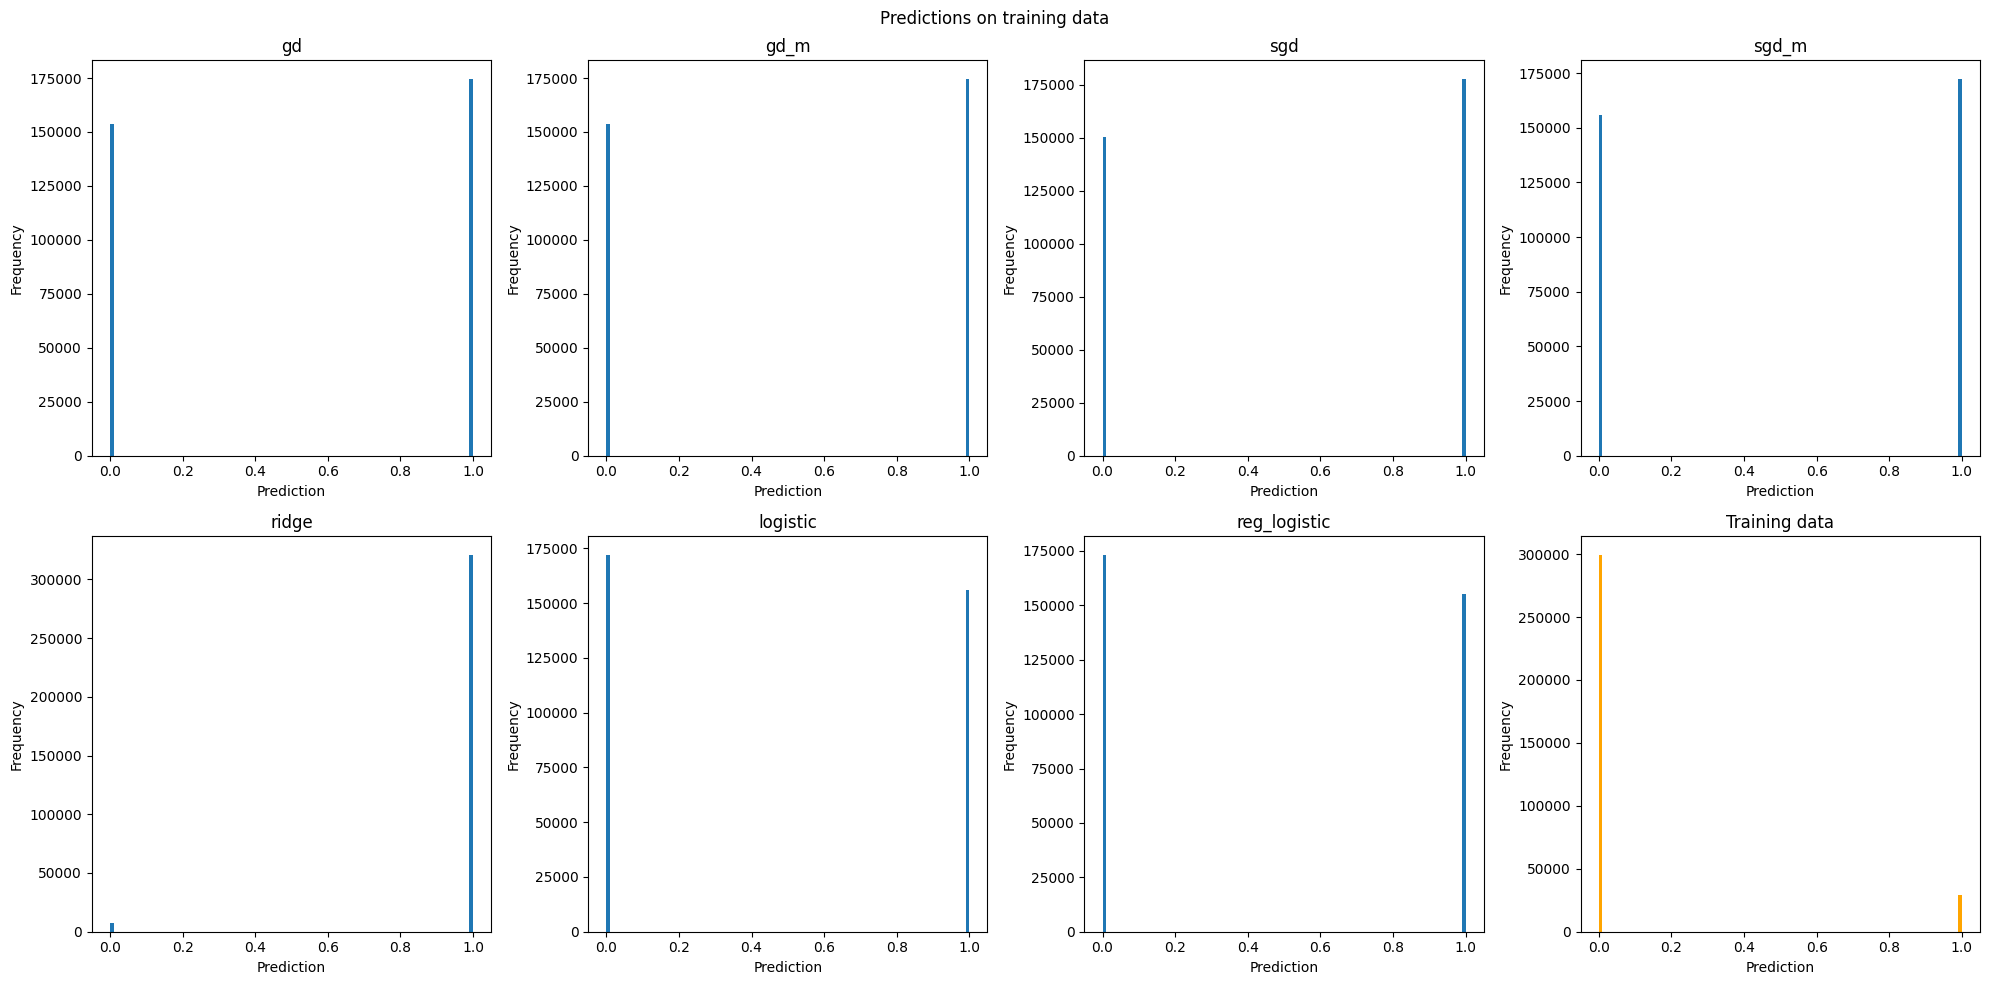

In [128]:

pred_plots = plt.figure(figsize=(20,10))
pred_plots.suptitle('Predictions on training data')
for p in range(7):
    pred_plots.add_subplot(2,4,p+1)
    plt.title(list(predictions.keys())[p])
    plt.hist(list(predictions.values())[p], bins=100)
    plt.xlabel('Prediction')
    plt.ylabel('Frequency')
pred_plots.add_subplot(2,4,8)
plt.hist(Y, bins=100, color='orange')
plt.title("Training data")
plt.xlabel('Prediction')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()
pred_plots.savefig('Predictions.png')

#print(predictions['sgd_m'])
#plt.hist(predictions['reg_logistic'], bins=100)


/var/folders/ty/wyjxd9cs6w36qdhf0vyyv21m0000gn/T/ipykernel_35095/74056989.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10', len(f1_scores))


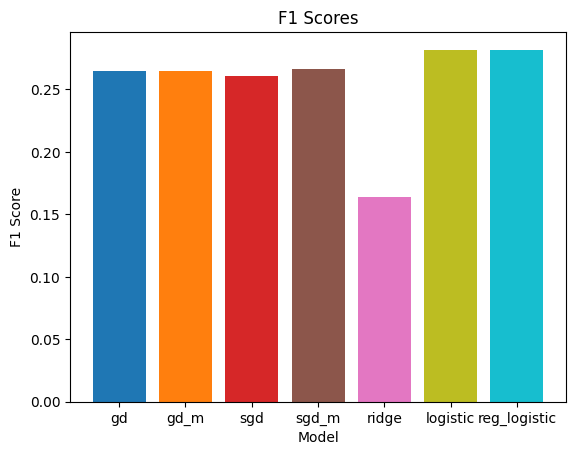

In [129]:
import matplotlib.cm as cm

# create a color map with the number of colors equal to the number of bars
cmap = cm.get_cmap('tab10', len(f1_scores))

# plot the bar chart with the color map
plt.bar(f1_scores.keys(), f1_scores.values(), color=cmap(range(len(f1_scores))))
plt.title('F1 Scores')
plt.xlabel('Model')
plt.ylabel('F1 Score')
plt.show()


In [136]:
#pred_logistic[pred_logistic == 0] = -1
predictions_submission = predictions['reg_logistic']
print(predictions_submission.shape)
predictions_submission[predictions_submission == 0] = -1
#predictions['reg_logistic'] = pred_reg_logistic
h.create_csv_submission(xTest[:,0],predictions_submission,'./Predictions/balancedDataNoPrior1028.csv')


(109379,)
